In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from astropy.io import fits
import fitsio

In [3]:
oba_sim_instrument = '../superbit_lensing/oba/sims/data/instrument/'
bands = ['lum']

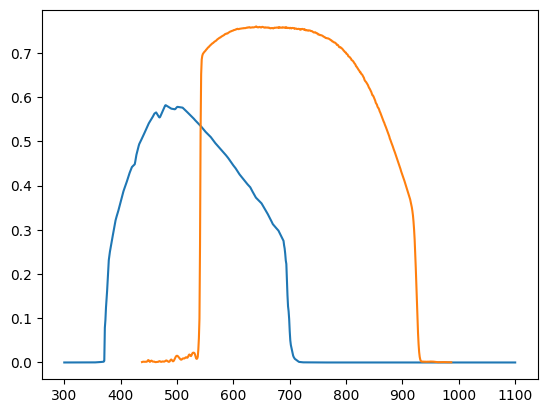

In [4]:
lum=Table.read(oba_sim_instrument + "bandpass/" + bands[0] + "_2023.csv")
plot(lum['wavelengths'],lum['transmission'])
vis=Table.read(oba_sim_instrument + "bandpass/vis.csv")
plot(vis['wavelengths'],vis['transmission'])

In [5]:
Table.read("euclid/euclid_test/Abell2813/det/cat/Abell2813_coadd_det_cat.fits")

ALPHAWIN_J2000,DELTAWIN_J2000,X_IMAGE,Y_IMAGE,NUMBER,KRON_RADIUS,BACKGROUND,THRESHOLD,FLAGS,CLASS_STAR,FLUX_RADIUS,FLUX_APER,ELLIPTICITY,SNR_WIN
deg,deg,pix,pix,,,ct,ct,,,pix,ct,,
float64,float64,float32,float32,int32,float32,float32,float32,int16,float32,float32,float32,float32,float32
10.8473064,-20.6764517,2622.2861,18.1315,1,3.06,0.09950317,0.03093447,0,0.238,2.542,5.599082,0.233,1.244
10.8673483,-20.6767193,1954.0999,9.9720,2,3.36,0.09932072,0.03093447,17,0.015,3.657,3.408182,0.499,1.11
10.8184381,-20.5563888,3586.0000,4298.4863,3,3.64,0.09967671,0.0309246,17,0.539,2.637,0.5101775,0.834,0.4132
10.8121155,-20.5563334,3797.0000,4298.9473,4,2.80,0.09966911,0.02746739,25,0.562,2.811,0.02681022,0.853,-0.1252
10.8137337,-20.5563209,3743.0000,4299.4087,5,3.77,0.09966008,0.02746739,25,0.378,3.295,0.136983,0.830,-0.1156
10.8138664,-20.5563269,3738.5686,4299.1958,6,2.50,0.09965941,0.02746739,25,0.585,3.012,0.1453561,0.729,0.2709
10.8154862,-20.5563214,3684.5168,4299.4087,7,4.00,0.09965975,0.02746739,25,0.642,3.543,0.1957696,0.701,0.4862
10.8186182,-20.5563339,3580.0000,4298.9932,8,3.94,0.09967729,0.02746739,25,0.646,3.042,0.1908299,0.851,0.3632


In [6]:
from superbit_lensing import cookiecutter

In [7]:
pwd

'/home/vitorelli/github/superbit-metacal/tests'

In [8]:
cookie=cookiecutter.CookieCutter(cookiecutter_file="euclid/euclid_test/Abell2813/vis/out/Abell2813_vis_cutouts.fits")
cookie.initialize()
cctable=Table.read(("euclid/euclid_test/Abell2813/vis/out/Abell2813_vis_cutouts.fits"),hdu=8)

In [9]:
cctable

object_id,xcen,ycen,start_index,end_index,sky_bkg,sky_var,img_ext
uint32,float64,float64,uint32,uint32,float64,float64,uint16
1,17.48833870709268,2576.1238526102225,0,256,-1.0,-1.0,0
2,7.977188865760127,1907.8452100795862,256,1280,-1.0,-1.0,0
95,4131.297578312035,2803.158219176083,1280,1536,-1.0,-1.0,0
96,4145.382527707323,3655.5375424820318,1536,2560,-1.0,-1.0,0
97,4128.359477296903,3548.7969988811565,2560,2816,-1.0,-1.0,0
98,4125.178787225318,2103.6539405567673,2816,3072,-1.0,-1.0,0
99,4125.253537739998,2014.0485940141562,3072,3328,-1.0,-1.0,0
100,4123.998560641996,490.61621405776805,3328,3584,-1.0,-1.0,0
101,4119.507970232278,3850.518609009047,3584,3840,-1.0,-1.0,0


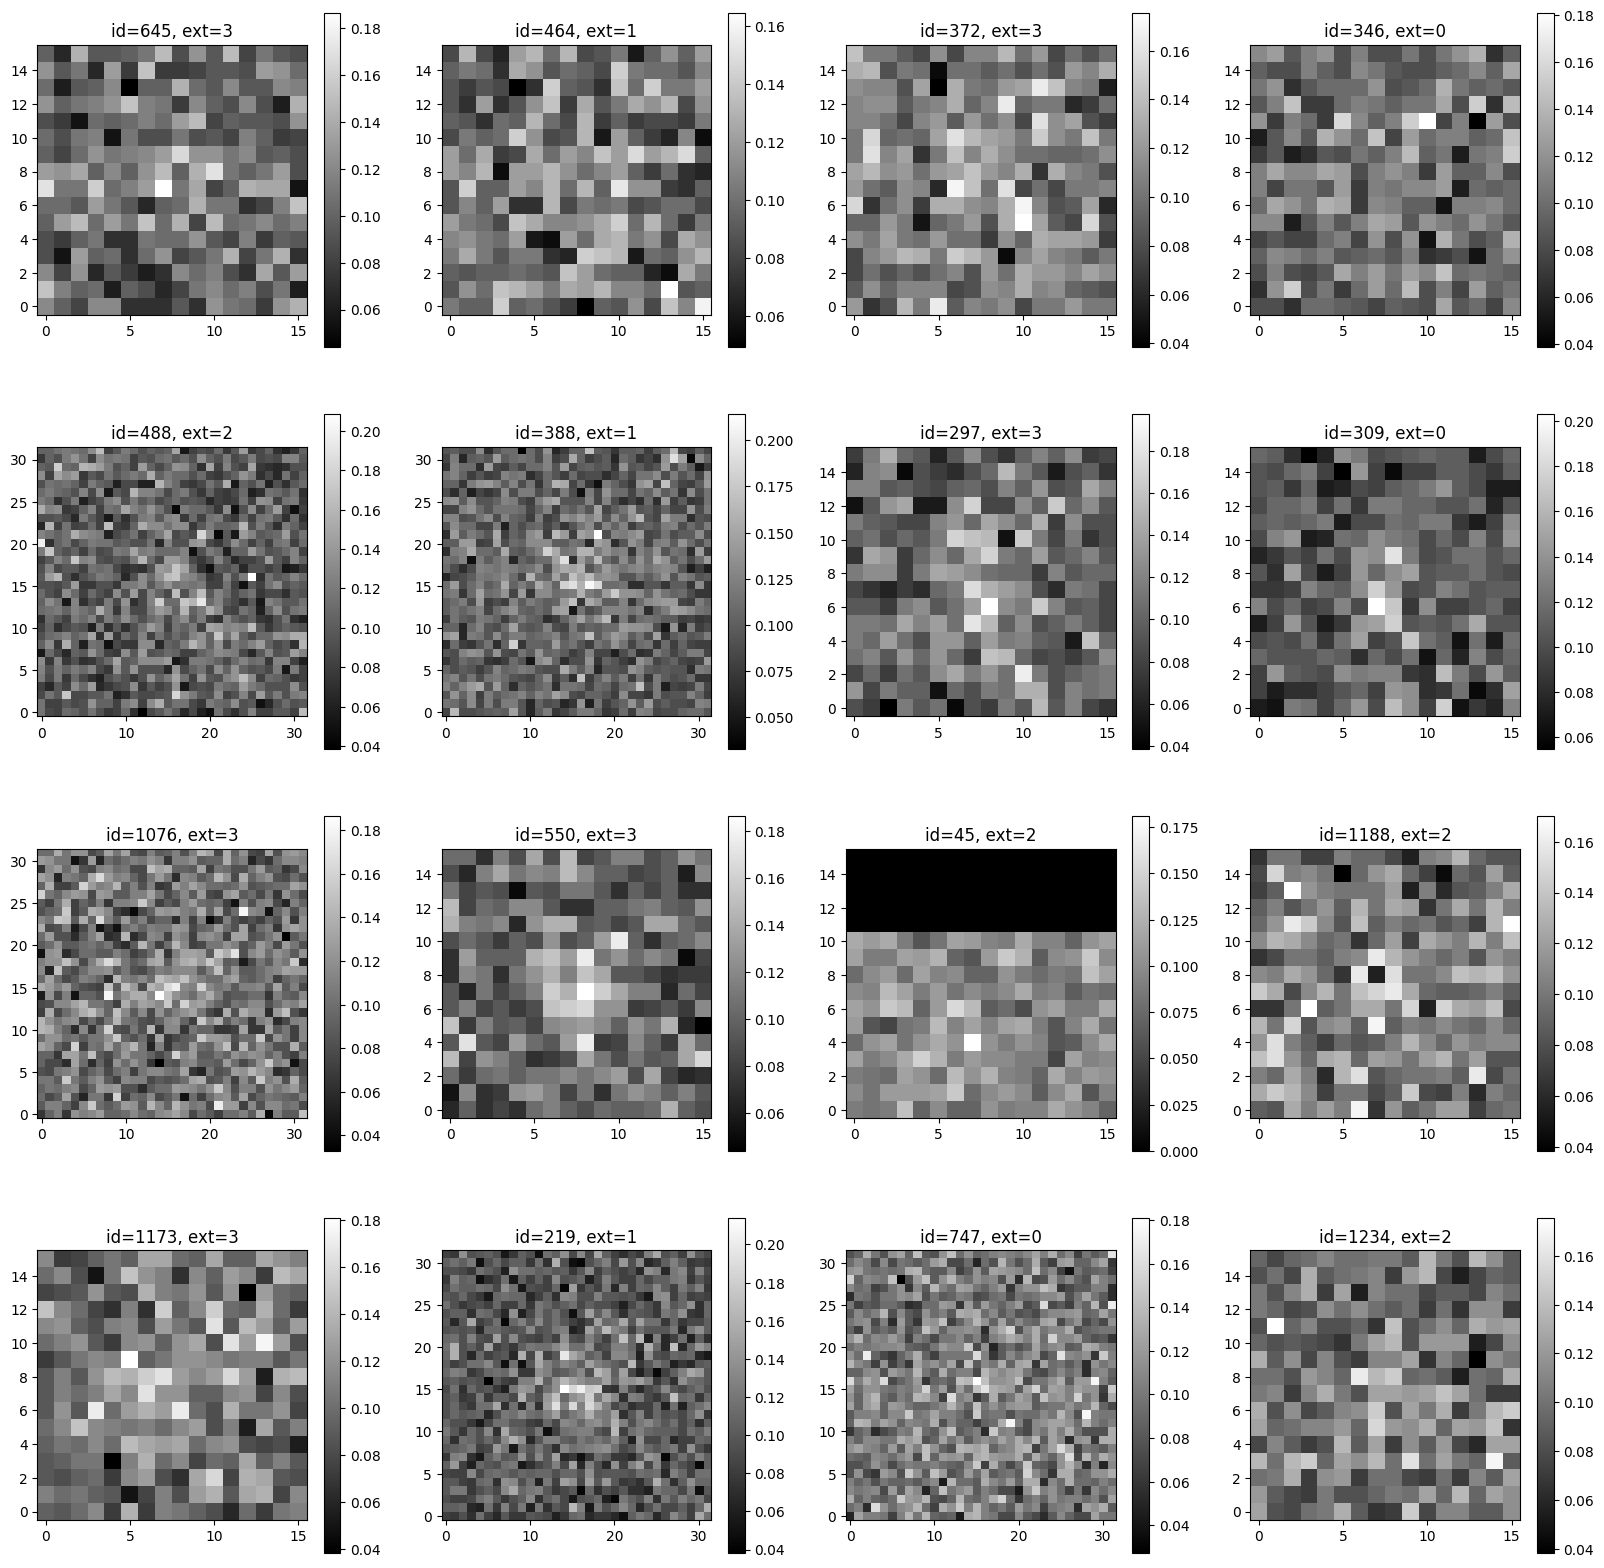

In [15]:
figure(figsize=(20,20))
pos = 0
while pos <  16:
  pos+=1
  choice = np.random.randint(0,len(cctable))
  obj_id = cctable[choice]['object_id']
  ext_no = cctable[choice]['img_ext']
  cut = cookie.get_cutout(obj_id,extnumber=ext_no)
  subplot(4,4,pos)
  imshow(cut,origin='lower',cmap='gist_gray');colorbar()
  title(f"id={obj_id}, ext={ext_no}")